# Lecture 2: Probability and Basic Learning Techniques
In this lecture we're going to cover the most basic examples of what it means to learn a problem, introducing some terminology along the way. We'll play with a few experiments that illustrate how real life situations relate to learning as well. Finally we'll introduce a simple classification problem using an actual dataset and solve it in a surprisingly straight forward way. For this lecture, one person at each table should open this notebook so we can have an more interactive lecture.

In [1]:
# start by importing some of the modules we're going to use for this lecture
import mxnet as mx
from mxnet import nd
from mxnet import gluon
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
import PIL
import requests
from io import BytesIO
from IPython.display import display
%matplotlib inline

# Coin Flip

Let's start with a very simple example of learning to see how probability and the number of observations made relate.

In [2]:
# get some pictures of coins that we can use to make things prettier!
heads_url = "http://www.thecoinspot.com/25c/1932%20Type%201%20Silver%20Washington%20Quarter%20Obv.png"
tails_url = "https://upload.wikimedia.org/wikipedia/commons/5/5a/98_quarter_reverse.png"
heads_img = requests.get(heads_url)
heads_img = PIL.Image.open(BytesIO(heads_img.content))
heads_img = heads_img.resize((80, 80), PIL.Image.ANTIALIAS)
tails_img = requests.get(tails_url)
tails_img = PIL.Image.open(BytesIO(tails_img.content))
tails_img = tails_img.resize((80, 80), PIL.Image.ANTIALIAS)

Now, lets assume that we have a weighted coin. That means that the probability of a flip resulting in heads is different from the probability of it being tails.

In [3]:
# generate a number between 0 and 1, this represents the probability our coin lands on heads. No Peeking!
flip_prob = np.random.rand(1)

Our goal is to figure out what the probability of flipping a heads with this coin is. The obvious way to do this is to simply flip some coins!

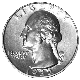

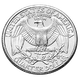

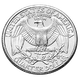

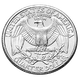

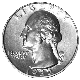

In [4]:
# set a number of flips to perform
flips = 5
# make a few variables to keep track of the results
results = []
heads_count = 0
tails_count = 0
# Perfrom some flips!
for i in range(flips):
    heads = np.random.rand(1) < flip_prob
    if heads:
        results.append(heads_img)
        heads_count += 1
    else:
        results.append(tails_img)
        tails_count += 1
        
display(*results)        

Great, we have some results. Of course the obvious way to estimate the flip probability is to simply look at our results and find the ratio of heads to total flips, lets do that.

In [5]:
estimated_p = heads_count / flips

In [6]:
def test_estimate(estimate, flip_prob):
    error = np.abs(estimate - flip_prob)*100
    print("Estimate is %f%% off" % error)

In [7]:
test_estimate(estimated_p, flip_prob)

Estimate is 4.692762% off


Unless you got pretty lucky, chances are that the error estimate is quite high.

## Activity:
How might you change the experiment to more accurately figure out the flip probability? Go back and try it out, make sure to measure the error again to see if you improved.

In [8]:
# If you need, you can write some code here.


## The Binomial Distribution
Let's formulate this problem a little more mathematically so we can understand what's happening and what the optimal solution is.

A sequence of events that are independent, identically distributed (same probability), and has one of two outcomes is said to be samples of the binomial distribution. In this case we have
* P(heads) $= \theta$, P(tails) $=  1 - \theta$.
* A sequence $D$ of $a_H$ heads (H) and $a_T$ tails (T)
* If we for example observed a sequence $D$ (H)(H)(T)(T)(H), then we could write
* P(D | $\theta$) $=$ P(HHTTH | $\theta$) = $\theta \times \theta \times (1 - \theta) \times (1 - \theta) \times \theta$
* If we knew the value of $\theta$ then we could calculate the probability of observing $D$.

Our goal is to learn the binomial distribution of these coin flips, and we'll have to do it from the experience of flipping the coin.

### Maximum Likelihood Estimation
* __Data__: Observed set $D$ of $a_h$ heads and $a_t$ tails
* __Hypothesis__: Events are samples of a binomial distribution
* __Goal__: learn $\theta$, this is an optimization problem
* __Objective Function__: $P(D|\theta) = \theta^{a_h} (1 - \theta)^{a_t}$

In other words, we want to find $\theta$ that maximizes the probability of observing $D$. This estimate of $\theta$ is called the __maximum likelihood estimator__.

$\hat{\theta}$ = argmax$_\theta$($P(D|\theta)$)

$= $argmax$_\theta($ln($P(D|\theta)$))

$= $argmax$_\theta($ln$(\theta^{a_H}(1 - \theta)^{a_T}))$

Since we are finding a maximum, we can set the derivitive to zero and solve for $\theta$

$\frac{d}{d\theta} ln (\theta^{a_H}(1 - \theta)^{a_T}) = 0$

$= \frac{d}{d\theta}(a_H \text{ln} (\theta) + a_T \text{ln} (1 - \theta))$

$\Rightarrow \frac{a_H}{\theta} - \frac{a_T}{1 - \theta} = 0$

$\Rightarrow \hat{\theta} = \frac{a_H}{a_H + a_T}$

$ = \frac{3}{3 + 2} = \boxed{\frac{3}{5}}$

That was a lot of work, but we proved what we expected. The best way to estimate the coin flips is simply to take the ratio of heads to the total number of observations.

It seems clear that if we want a better approximation of $\theta$, we simply need to make more observations, but how many observations is enough?

### Hoeffding's Inequality Bound
For $N$ observations and $\hat{\theta}_{\text{MLE}} = \frac{a_H}{a_H + a_T}$, let $\theta^*$ be the true flip probability

$P(|\hat{\theta}_{\text{MLE}} - \theta^*| \geq \epsilon) \leq 2 e^{-2N\epsilon^2}$

where $\epsilon$ is some small error tolerance, say 0.1. In other words, the probability of getting a bad MLE decreases exponentially the more observations are made. Let's look a little closer at this

In [9]:
import math
epsilon = 0.1
def Hoeffding(N):
    return 2 * math.exp(- 2 * N * epsilon**2) 

Text(0,0.5,'Probability of error')

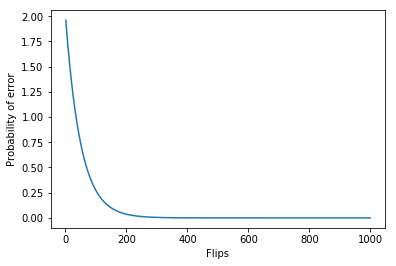

In [10]:
error_prob = []
for i in range(1,1000):
    error_prob.append(Hoeffding(i))
    
plt.plot(list(range(1,1000)), error_prob)
plt.xlabel("Flips")
plt.ylabel("Probability of error")

We see that we expect to start being pretty accurate at around 200 flips, lets see how this compares to real life.

In [11]:
# lets perform 400 experiments. In each, we'll flip some number of coins and record how well 
# the observed flips match the true probability

error_prob = []
for i in range(1, 400):
    # do some smoothing
    error_sum = 0
    for j in range(1, 100):
        flips = np.random.rand(i) < flip_prob
        MLE_prob = np.sum(flips) / len(flips)
        error_sum += (np.abs(MLE_prob - flip_prob))
    error_prob.append(error_sum / 100)

Text(0,0.5,'Error')

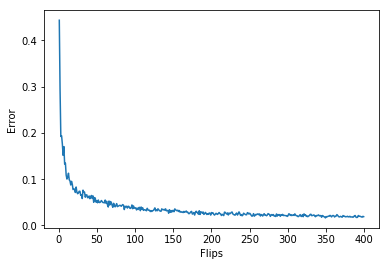

In [12]:
plt.plot(list(range(1, 400)), error_prob)
plt.xlabel("Flips")
plt.ylabel("Error")

That looks pretty similar! Of course, they're not measuring exactly the same thing, but they both clearly show that more observations is good!

## Continuous Variables
You might be worried that what we just learned only applies to simple things like coin flips. However, all the concepts transfer perfectly well to other distributions, including continous values

Most often, real life random samples will come from the Gaussian distribution

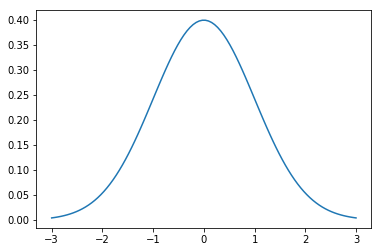

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

A gaussian distribution is defined by a mean ($\mu$) (average value) and a standard deviation ($\delta$) (how far from the mean things tend to fall). Both of these values are fairly easy to compute from observed data.

$\mu = \sum\limits_{N} \frac{x}{N}$

$\delta = \sum\limits_{N} (x - \mu)^2$

## Activity: Gaussian Height
You'll find that many things in life are normally distributed, one common example is height. Let's try it out and see how the heights of people in the room look. To make things simple, I've provided some utility tools below, start with your table, then branch out to other tables as well

In [14]:
def feet_to_cm(feet, inches):
    total_inches = 12*feet + inches
    return 2.54 * total_inches

def compute_mean_and_std(cm_list):
    return np.mean(cm_list), np.std(cm_list)

def plot_heights(cm_list):
    n, bins, patches = plt.hist(cm_list, 10)
    plt.show()        

In [15]:
# example of how to use this
# cm_list = [feet_to_cm(6, 2), feet_to_cm(5, 8), feet_to_cm(5, 6)]
# mean, std = compute_mean_and_std(cm_list)
# plot_heights(cm_list)

table_cm_list = []
class_cm_list = []

The national average height is around 170 cm and the standard deviation is 7.1 cm. How did we compare?

# Regression

All machine learning has its roots in trying to learn probability distributions, however, those distributions are not always so clean cut. In regression, we are instead trying to learn a function between input variables and an output variable.

To explore the idea of regression a little, lets take a look at the Iris Dataset.

![Iris](https://archive.ics.uci.edu/ml/assets/MLimages/Large53.jpg)

iris is made up of data collected from three different kinds of iris flowers. Each recorded sample has 4 features
* sepal length in cm
* sepal width in cm
* petal length in cm
* petal width in cm

and one of three different classes
* Iris Setosa
* Iris Versicolour
* Iris Virginica

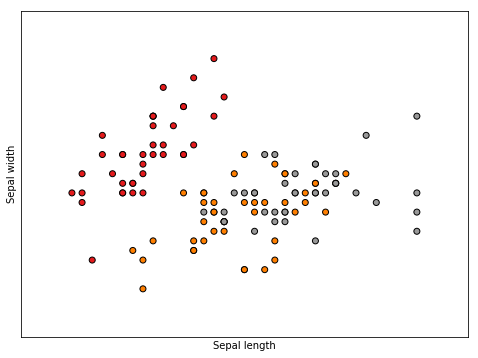

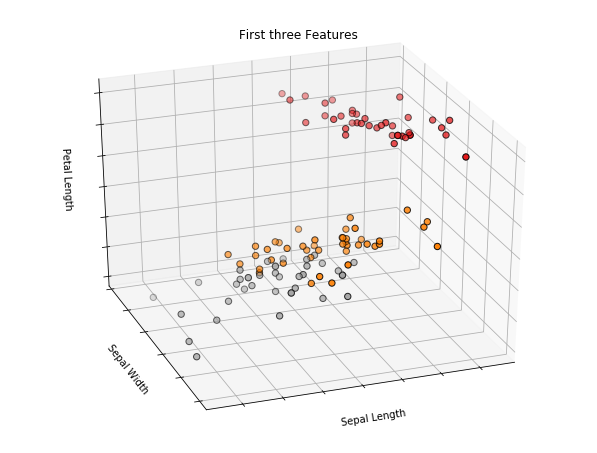

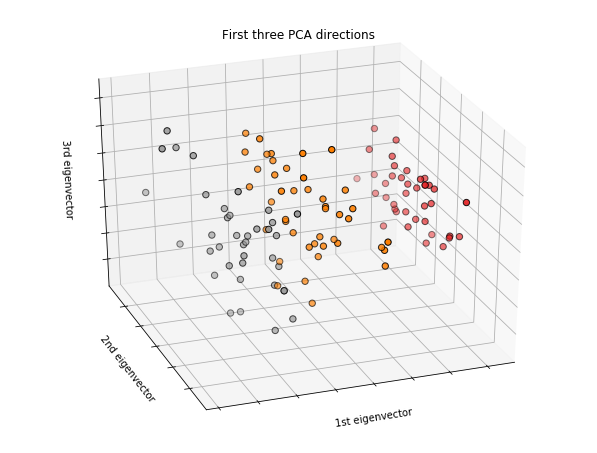

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

iris = datasets.load_iris()

iris_data, iris_labels = shuffle(iris.data, iris.target)
train_data = iris_data[:120]
train_labels = iris_labels[:120]
val_data = iris_data[120:]
val_labels = iris_labels[120:]

# import some data to play with
X = train_data[:, :2]  # we only take the first two features.
y = train_labels

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(3, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# lets also show with three features
fig = plt.figure(2, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = train_data[:, :3]
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three Features")
ax.set_xlabel("Sepal Length")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Sepal Width")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Petal Length")
ax.w_zaxis.set_ticklabels([])

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(train_data)
#X_reduced = iris.data[:, :3]
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

Above we load the dataset and make some visuals to see how the different classes relate to the features. It's pretty clear that the features do give us some information about the class! This is apparent because the different color dots can be visually seperated, great! That means it should be fairly easy for us to learn the function that maps the features to a class.

But how should learn that function? It turns out there are a lot of techniques that will work, can you think of one?

# Activity: Custom Regression
In this activity youll get to take the measurements on a new iris flower. Given previous observations, figure out what type of flower you're now looking at. There are a lot of right ways to do this so be creative!

In [18]:
# Here are the previous observations you've made, they are also plotted above.
previous_data = train_data
previous_label = train_labels

observation_indices = [0]

# and now, here is a new observation without a label
new_flower = val_data[0]
print(new_flower)

[ 6.1  2.8  4.7  1.2]


You're job is to figure out which class this belongs to

In [19]:
# fill in whatever code you need here:


# put your guess (either 0, 1, 2) here
guess = '?'

for i in observation_indices:
    if (guess[i] == val_labels[i]):
        print("correct")
    else:
        print("incorrect")

incorrect


Now, lets try applying classifying a bunch of new flowers! See if you can adapt your technique.

In [20]:
observation_indices = list(range(10))
# put your code to guess 10 flowers classes here


# generate a list of your guesses if possible
guess = list(range(10))

for i in observation_indices:
    if (guess[i] == val_labels[i]):
        print("correct")
    else:
        print("incorrect")

incorrect
incorrect
incorrect
incorrect
incorrect
incorrect
incorrect
incorrect
incorrect
incorrect


### A Simple Solution: KNN
If you're working on the previous activity, stop peeking! Otherwise, let's talk about one possible solution. The idea is to simply classify a new observation $x$ as whichever type of flower is most similar. This technique is known as K-nearest-neighbors classification.

Let's first define what it means for $x$ to be similar to another observation. Each feature of an observation can be thought of as a point in Cartesian space, similar to the plots above. In this case, the similarity between two observations is simply their Euclidean distance.

$D(x, x') = \sqrt{\sum\limits_{j=1}^d (x[j] - x'[j])^2}$ 

Lets check out a simple example to illustrate how this works

Text(0,0.5,'Sepal width')

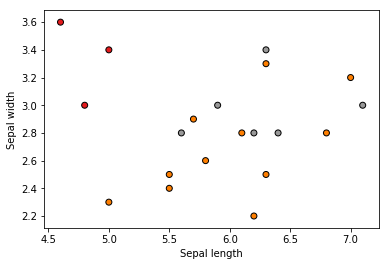

In [21]:
# take a few observations so things are easier to see

simple_data = iris_data[:20][:, :2]
simple_labels = iris_labels[:20]

X = simple_data
y = simple_labels
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

Text(0,0.5,'Sepal width')

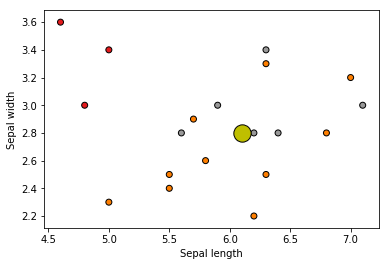

In [22]:
# Now, lets add a new observation
new_observation = val_data[0][:2]
# add it to the plot
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.scatter(new_observation[0], new_observation[1], c='y', cmap=plt.cm.Set1,
            edgecolor='k', s=300)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

The yellow dot here is our new observation. Let's compute the knn approximation for k = 5.

In [23]:
obs_x = new_observation[0]
obs_y = new_observation[1]
# compute the distance between our observation and all the training data, note that this is done as an array function
distances = (X[:, 0] - obs_x)**2 + (X[:, 1] - obs_y)**2

Now that we have the distances, we want to find the labels of the points closest to our observation, we're going to do this using the mxnet function topk, which finds the k smallest values when is_ascend is set to True.

In [24]:
closest_points = nd.topk(nd.array(distances), k=5, is_ascend=True).asnumpy().astype(np.int)
closest_labels = y[closest_points]
print("Nearest Labels: ", closest_labels)
best_guess = np.argmax(np.bincount(closest_labels))
print("Best Guess: ", best_guess)
print("Real Label: ", val_labels[0])

Nearest Labels:  [1 2 2 2 1]
Best Guess:  2
Real Label:  1


Hopefully we got it right (at least I did when testing). Neat! Lets implement KNN classification on the entire validation set and see how we do! Since we're not going to plot anymore, we'll also use all 4 features to get extra accuracy.

In [25]:
# lets define some utility functions to make things cleaner

def euclid_distance(a, b):
    return np.linalg.norm(a - b)

def get_neighbors(distances, k=5):
    closest_points = nd.topk(nd.array(distances), k=5, is_ascend=True).asnumpy().astype(np.int)
    return [train_labels[point] for point in closest_points]

def best_guess(labels):
    return np.argmax(np.bincount(labels))      

In [26]:
guesses = []

for observation in val_data:
    d = np.asarray([euclid_distance(observation, neighbor) for neighbor in train_data])
    knn = get_neighbors(d)
    guess = best_guess(knn)
    guesses.append(guess)

In [27]:
print(guesses == val_labels)
accuracy = np.mean(guesses==val_labels)
print("Total Accuracy: %f%%" % (100*accuracy))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True False  True]
Total Accuracy: 93.333333%


Hopefully we see a bunch of Trues, that means we got the right guess and KNN is a success! If there are some False answers, what might you change to improve our accuracy? Feel free to tweak the code to get some improvements in accuracy.